# Import data from Google Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
# files present in dataset
!ls '/content/drive/MyDrive/CS267 Dataset/chest_xray/'

input_path = '/content/drive/MyDrive/CS267 Dataset/chest_xray/chest_xray/'

chest_xray  test  train  val



# Import Libraries

In [35]:
import os
import random as rn
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import  LabelEncoder
from sklearn import metrics

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.applications.vgg16 import VGG16

# Input paths

In [18]:
# paths for train, test and validate data

train_data = input_path + 'train/'
test_data = input_path + 'test/'
val_data = input_path + 'val/'

# training data sub-folders
print(os.listdir(train_data))
train_normal = train_data + 'NORMAL/'
train_pneumonia = train_data +'PNEUMONIA/'

['NORMAL', 'PNEUMONIA']


# Data Augmentation

In [19]:
batch_size = 16

In [20]:
# using ImageDataGenerator for data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
train_dataset = train_datagen.flow_from_directory(train_data, batch_size = batch_size, target_size = (224, 224), class_mode = 'binary')
test_dataset = test_datagen.flow_from_directory(test_data, batch_size = batch_size, target_size = (224, 224), class_mode = 'binary')
val_dataset = test_datagen.flow_from_directory(val_data, batch_size = batch_size, target_size = (224, 224), class_mode = 'binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Create VGG16 Model

In [22]:
# create VGG16 model
vgg16_model = VGG16(include_top = False, input_shape = (224, 224, 3), pooling = 'max')

In [23]:
# model summary
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
# add new fully connected layers to the model

model = Sequential()
model.add(vgg16_model)

model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [25]:
# use pretrained VGG16 as a feature extractor for the dataset, and use our layers on those features
vgg16_model.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
# compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
batch_size = 16

steps_per_epoch = len(train_dataset) // batch_size
print('Number of steps per epoch: ', steps_per_epoch)

validation_steps = len(test_dataset) // batch_size
print('Number of validation steps: ', validation_steps)

steps = len(test_dataset) // batch_size
print('Steps for evaluation: ', steps)


Number of steps per epoch:  20
Number of validation steps:  2
Steps for evaluation:  2


In [28]:
my_model = model.fit(train_dataset, validation_data = val_dataset, steps_per_epoch = steps_per_epoch, epochs = 10, validation_steps = validation_steps, batch_size = batch_size, verbose = 1)

Epoch 1/10
20/20 [==============================] - 65s 3s/step - loss: 0.6305 - accuracy: 0.6594 - val_loss: 1.2786 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 56s 3s/step - loss: 0.3531 - accuracy: 0.8375
Epoch 3/10
20/20 [==============================] - 51s 3s/step - loss: 0.2957 - accuracy: 0.8687
Epoch 4/10
20/20 [==============================] - 48s 2s/step - loss: 0.2254 - accuracy: 0.8906
Epoch 5/10
20/20 [==============================] - 44s 2s/step - loss: 0.2483 - accuracy: 0.8906
Epoch 6/10
20/20 [==============================] - 45s 2s/step - loss: 0.2853 - accuracy: 0.8719
Epoch 7/10
20/20 [==============================] - 43s 2s/step - loss: 0.1960 - accuracy: 0.9219
Epoch 8/10
20/20 [==============================] - 45s 2s/step - loss: 0.1680 - accuracy: 0.9406
Epoch 9/10
20/20 [==============================] - 40s 2s/step - loss: 0.2147 - accuracy: 0.9281
Epoch 10/10
20/20 [==============================] - 35s 2s/step - loss: 0.2

In [30]:
test_accuracy = model.evaluate(test_dataset, steps = steps, batch_size = batch_size)

2/2 [==============================] - 3s 3s/step - loss: 0.2547 - accuracy: 0.8750


In [31]:
print('Testing accuracy: ', test_accuracy[1] * 100)

Testing accuracy:  87.5


In [33]:
predict = model.predict(test_dataset)

In [39]:
predict = (predict > 0.5).astype('int32')

In [44]:
print(metrics.classification_report(test_dataset.labels, predict))

              precision    recall  f1-score   support

           0       0.43      0.34      0.38       234
           1       0.65      0.73      0.69       390

    accuracy                           0.58       624
   macro avg       0.54      0.54      0.53       624
weighted avg       0.57      0.58      0.57       624



AUC for ROC: 0.535042735042735
 


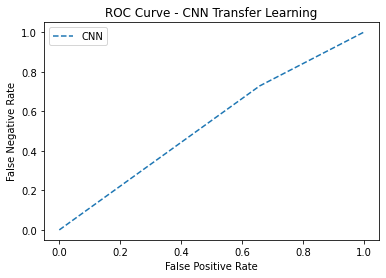

AUR for PR: 0.7732393747804707



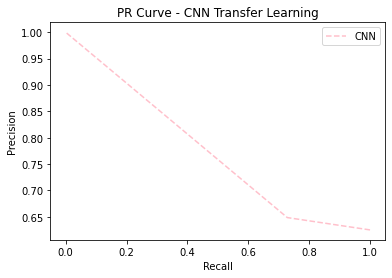

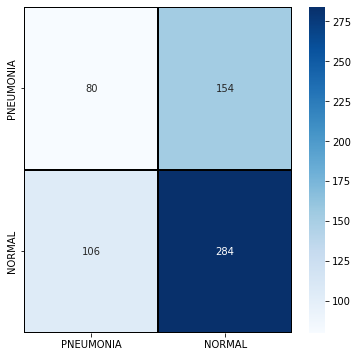

In [42]:
get_roc_curve(test_dataset.labels, predict, 'CNN Transfer Learning', 'CNN')
get_pr_curve(test_dataset.labels, predict, 'CNN Transfer Learning', 'CNN')
get_confusion_matrix(test_dataset.labels, predict)

# Plot Graph

In [37]:
def get_roc_curve(y_test, y_predict, title, label):
    fpr, tpr, _ = metrics.roc_curve(y_true = y_test, y_score = y_predict)
    auc_roc = metrics.roc_auc_score(y_true = y_test, y_score = y_predict)
    print('AUC for ROC: %s\n ' % auc_roc)

    plt.plot(fpr, tpr, linestyle = '--', label = label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative Rate')
    plt.title('ROC Curve - ' + title)
    plt.legend()
    plt.show()

def get_pr_curve(y_test, y_predict, title, label):
    precision, recall, _ = metrics.precision_recall_curve(y_true = y_test, probas_pred = y_predict)
    auc_pr = metrics.auc(recall, precision)
    print('AUR for PR: %s\n' % auc_pr)

    plt.plot(recall, precision, linestyle = '--', color = 'pink', label = label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve - ' + title)
    plt.legend()
    plt.show()

def get_confusion_matrix(y_test, y_predict):
    c_matrix = metrics.confusion_matrix(y_test, y_predict)
    plt.figure(figsize = (6,6))
    labels = ['PNEUMONIA', 'NORMAL']
    sns.heatmap(c_matrix ,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)